## Regression Model Pipeline


**use california hosuing dataset to predict price**
#### 1. Data load 및 Data 형태 확인
**회귀 문제용 데이터셋 - 캘리포니아 주택 가격 데이터 예시**




캘리포니아 주택 가격 예측 - 회귀 모델
특성 행렬 형태: (20640, 8)
타겟 벡터 형태: (20640,)

데이터 상위 5개 행:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0       NaN        NaN       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467       NaN   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

타겟 변수: 주택 가격 중앙값 (단위: $100,000)
타겟 변수 설명: **Data Set Characteristics:**

기본 통계량:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  19622.000000  19617.000000  19606.000000  19640.000000  19595.000000   
mean       3.872807     28.622012      5.428931      1.096219   1422.772544   
std        1.901047     12.583174      2.488565      0.

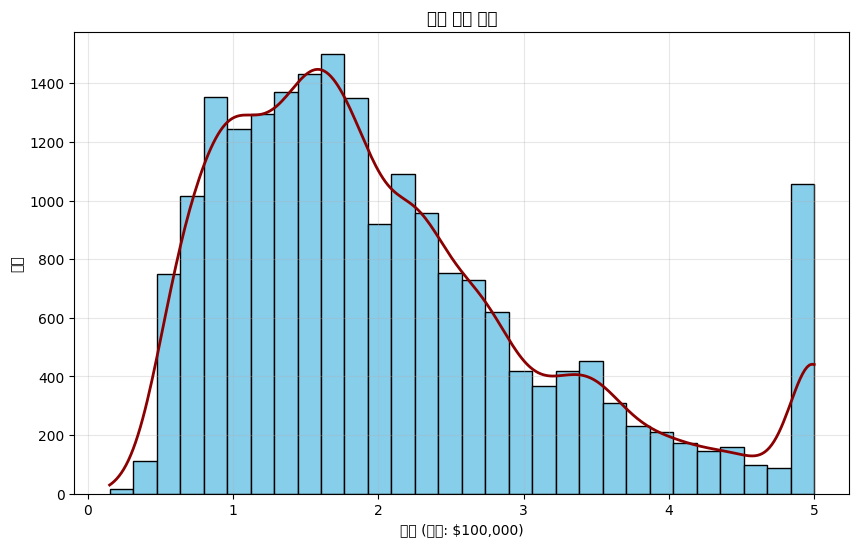

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

print("\n\n" + "="*50)
print("캘리포니아 주택 가격 예측 - 회귀 모델")
print("="*50)

# 1. Data load 및 Data 형태 확인
# 회귀 문제용 데이터셋 - 캘리포니아 주택 가격 데이터 예시
from sklearn.datasets import fetch_california_housing

# 데이터 로드
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

# 인위적으로 결측치 추가 (데이터 실전성 높이기)
np.random.seed(42)
for col in X.columns:
    # 각 컬럼의 약 5%를 결측치로 설정
    mask = np.random.rand(len(X)) < 0.05
    X.loc[mask, col] = np.nan

# 데이터셋 정보 확인
print("특성 행렬 형태:", X.shape)
print("타겟 벡터 형태:", y.shape)

# 데이터 상위 5개 행 확인
print("\n데이터 상위 5개 행:")
print(X.head())

# 타겟 설명
print("\n타겟 변수: 주택 가격 중앙값 (단위: $100,000)")
print("타겟 변수 설명:", housing.DESCR.split('\n')[5])

# 기본 통계량 확인
print("\n기본 통계량:")
print(X.describe())

# 결측치 확인
print("\n결측치 개수:")
missing_values = X.isnull().sum()
print(missing_values)
missing_percent = missing_values / len(X) * 100
print("\n결측치 비율(%):")
print(missing_percent)

# 타겟 변수 분포 시각화
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(y, bins=30, color='skyblue', edgecolor='black')

# 타겟 변수 분포의 KDE 곡선 추가
kde = gaussian_kde(y)
x_vals = np.linspace(min(y), max(y), 300)
plt.plot(x_vals, kde(x_vals)*len(y)*(bins[1]-bins[0]), color='darkred', linewidth=2)
plt.title('주택 가격 분포')
plt.xlabel('가격 (단위: $100,000)')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)
plt.show()



#################################################
#### 2: NaN 값 처리 및 EDA
#################################################


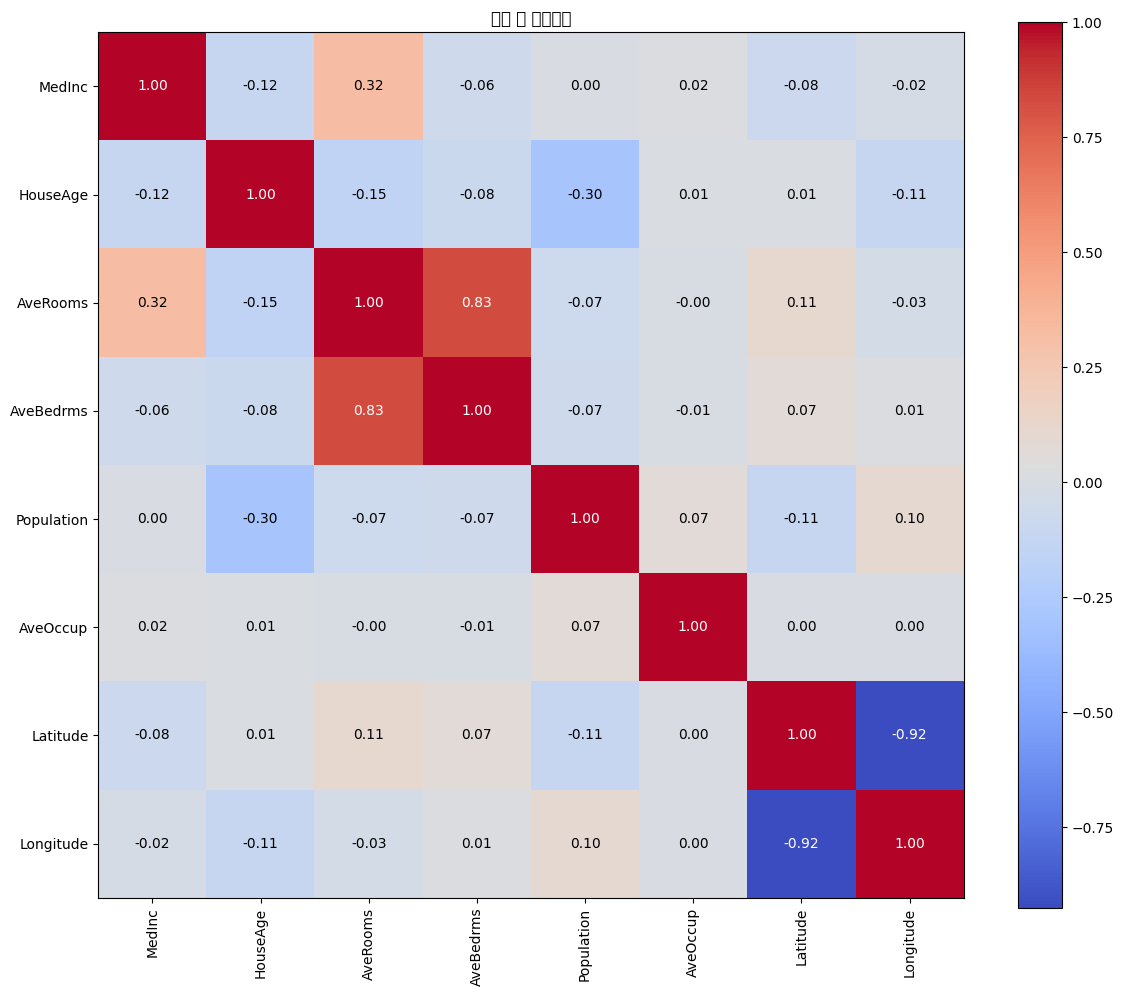

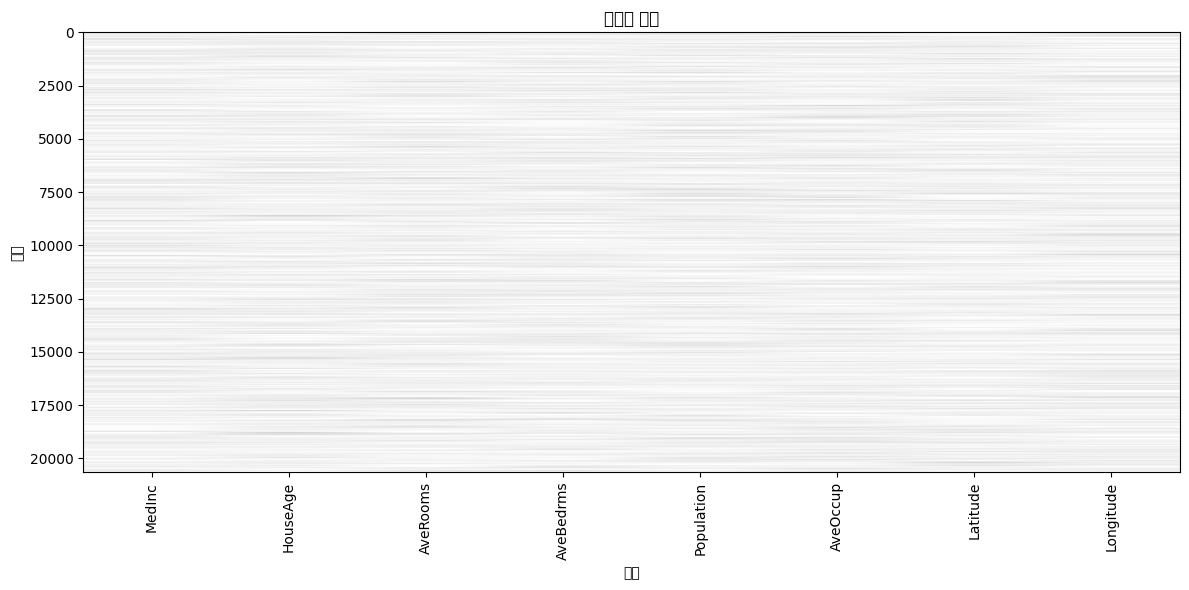

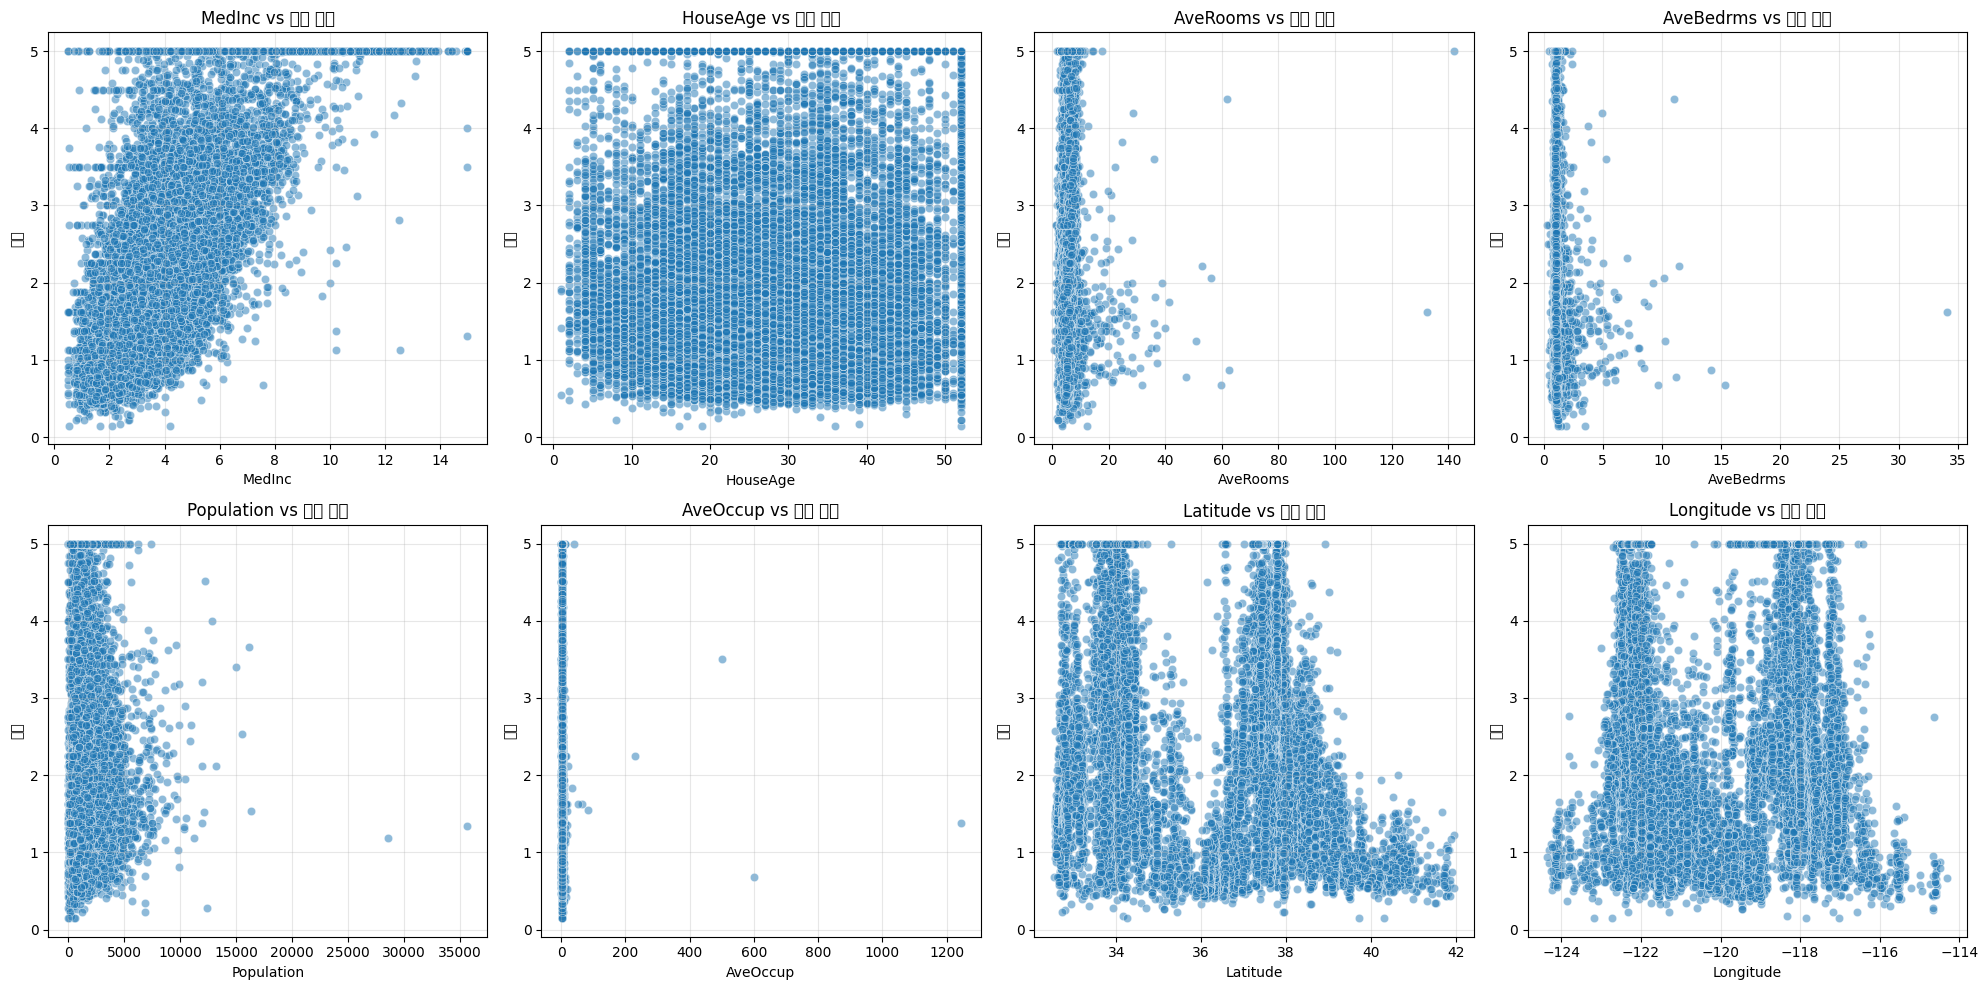

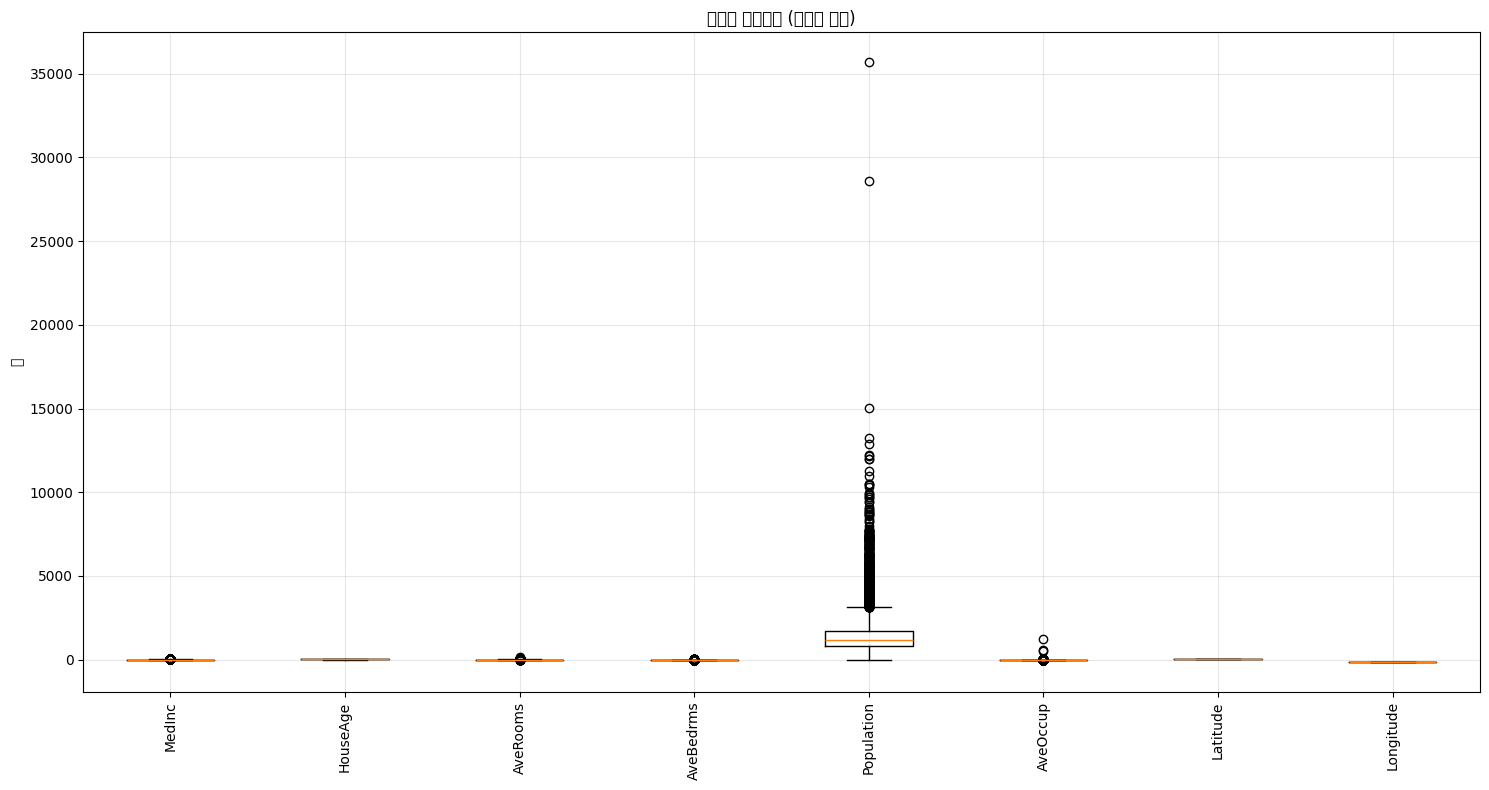


결측치 처리 전략:
1. 수치형 특성 결측치: KNN Imputer 사용 (이웃 데이터 참조)
2. 이상치 처리: IQR 방식으로 상한/하한 값 설정


In [2]:
# 2. NaN 값 처리 및 EDA
# 특성 간 상관관계 분석 (결측치 제외)
corr_matrix = X.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none', aspect='equal')
plt.colorbar()
plt.title('특성 간 상관관계')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

# 상관계수 값 텍스트로 표시
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                ha='center', va='center',
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
plt.tight_layout()
plt.show()

# 결측치 패턴 시각화
plt.figure(figsize=(12, 6))
plt.imshow(X.isnull(), cmap='binary', aspect='auto')
plt.title('결측치 패턴')
plt.xlabel('특성')
plt.ylabel('샘플')
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.tight_layout()
plt.show()

# 타겟 변수와 각 특성 간의 산점도 (결측치 제외)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    # 결측치를 제외한 데이터로 산점도 그리기
    valid_idx = ~X[feature].isnull()
    axes[i].scatter(X[feature][valid_idx], y[valid_idx], alpha=0.5, edgecolors='w', linewidth=0.5)
    axes[i].set_title(f'{feature} vs 주택 가격')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('가격')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 이상치 확인 - 박스플롯
plt.figure(figsize=(15, 8))
# X에서 결측치를 제외한 데이터로 박스플롯 생성
X_no_null = X.dropna()
plt.boxplot(X_no_null.values, labels=X.columns)
plt.title('특성별 박스플롯 (이상치 확인)')
plt.ylabel('값')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 결측치 처리 전략 정리
print("\n결측치 처리 전략:")
print("1. 수치형 특성 결측치: KNN Imputer 사용 (이웃 데이터 참조)")
print("2. 이상치 처리: IQR 방식으로 상한/하한 값 설정")



#################################################
#### 3. Preprocessing
#################################################

In [3]:
# 3. Preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 전처리 함수 정의
def preprocess_housing_data(X, y=None, is_train=True):
    # 데이터 복사
    X_copy = X.copy()

    # 결측치 처리: KNN Imputer
    print("KNN Imputer로 결측치 처리 중...")
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = imputer.fit_transform(X_copy)
    X_imputed = pd.DataFrame(X_imputed, columns=X_copy.columns)

    # 이상치 처리
    def handle_outliers(df, column):
        """IQR 방법을 사용하여 이상치를 탐지하고 상한/하한 값으로 대체"""
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치 대체
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        return df

    print("이상치 처리 중...")
    for column in X_imputed.columns:
        X_imputed = handle_outliers(X_imputed, column)

    # 특성 추가 (비율, 제곱 등)
    print("특성 추가 중...")
    # 방 개수 대 침실 개수 비율
    X_imputed['BedroomRatio'] = X_imputed['AveBedrms'] / (X_imputed['AveRooms'] + 0.001)  # 0으로 나누기 방지
    # 인구 밀도
    X_imputed['PopulationDensity'] = X_imputed['Population'] / (X_imputed['AveOccup'] + 0.001)

    # 범주형 변수 생성 (특성 범주화)
    print("범주형 변수 생성 중...")
    # 중앙 소득 범주화
    X_imputed['IncomeCategory'] = pd.cut(
        X_imputed['MedInc'],
        bins=[0, 2, 4, 6, 8, np.inf],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
    )

    # 위치 기반 범주화 (위도, 경도를 기준으로 지역 구분)
    X_imputed['Location'] = 'Other'
    # San Francisco Bay Area (대략적인 좌표)
    mask_sf = (X_imputed['Longitude'] > -123) & (X_imputed['Longitude'] < -121) & \
              (X_imputed['Latitude'] > 37) & (X_imputed['Latitude'] < 38.5)
    X_imputed.loc[mask_sf, 'Location'] = 'SF Bay Area'

    # Los Angeles Area
    mask_la = (X_imputed['Longitude'] > -119) & (X_imputed['Longitude'] < -117) & \
              (X_imputed['Latitude'] > 33.5) & (X_imputed['Latitude'] < 34.5)
    X_imputed.loc[mask_la, 'Location'] = 'LA Area'

    # 주택 나이 범주화
    X_imputed['HouseAgeCategory'] = pd.cut(
        X_imputed['HouseAge'],
        bins=[0, 10, 20, 40, np.inf],
        labels=['New', 'Recent', 'Old', 'Very Old']
    )

    return X_imputed

# 전처리 적용
X_processed = preprocess_housing_data(X)

print("\n전처리 후 데이터 형태:", X_processed.shape)
print("전처리 후 데이터 미리보기:")
print(X_processed.head())

# 범주형 변수 확인
categorical_features = X_processed.select_dtypes(include=['category', 'object']).columns.tolist()
print("\n범주형 변수:", categorical_features)

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

print("\n훈련 데이터 형태:", X_train.shape)
print("테스트 데이터 형태:", X_test.shape)



KNN Imputer로 결측치 처리 중...
이상치 처리 중...
특성 추가 중...
범주형 변수 생성 중...

전처리 후 데이터 형태: (20640, 13)
전처리 후 데이터 미리보기:
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  7.969863      41.0  6.984127   1.023810       322.0  2.555556    37.880   
1  7.969863      21.0  6.238137   0.971880      2401.0  2.109842    37.860   
2  7.257400      52.0  5.130779   0.969826       496.0  2.802260    37.850   
3  5.643100      52.0  5.817352   1.073059       558.0  2.547945    37.850   
4  3.846200      52.0  6.281853   1.081081       565.0  2.181467    37.956   

   Longitude  BedroomRatio  PopulationDensity IncomeCategory     Location  \
0    -122.23      0.146570         125.950715           High  SF Bay Area   
1    -122.22      0.155772        1137.460879           High  SF Bay Area   
2    -122.24      0.188984         176.936859           High  SF Bay Area   
3    -122.25      0.184427         218.914082         Medium  SF Bay Area   
4    -122.25      0.172068         258.8

#################################################
#### 4. 인코딩 및 모델 선택/학습
#################################################

In [4]:
# 4. 인코딩 및 모델 선택/학습
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# 수치형, 범주형 특성 분리
numeric_features = X_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_processed.select_dtypes(include=['category', 'object']).columns.tolist()

print(f"수치형 특성: {numeric_features}")
print(f"범주형 특성: {categorical_features}")

# 전처리 파이프라인 생성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# 모델별 파이프라인 생성
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]),
    'Lasso Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=0.01))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ])
}

# 각 모델 학습 및 평가
results = {}

for name, model in models.items():
    # 모델 학습
    print(f"\n{name} 모델 학습 중...")
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가 메트릭 계산
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 결과 저장
    results[name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"{name} 성능:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}")

# 성능이 가장 좋은 모델 선택 (R^2 기준)
best_model_name = max(results, key=lambda k: results[k]['r2'])
print(f"\n최고 성능 모델: {best_model_name}")
print(f"R^2 점수: {results[best_model_name]['r2']:.4f}")



수치형 특성: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'BedroomRatio', 'PopulationDensity']
범주형 특성: ['IncomeCategory', 'Location', 'HouseAgeCategory']

Linear Regression 모델 학습 중...
Linear Regression 성능:
  MSE: 0.4616
  RMSE: 0.6794
  MAE: 0.5013
  R^2: 0.6477

Ridge Regression 모델 학습 중...
Ridge Regression 성능:
  MSE: 0.4616
  RMSE: 0.6794
  MAE: 0.5013
  R^2: 0.6477

Lasso Regression 모델 학습 중...
Lasso Regression 성능:
  MSE: 0.4733
  RMSE: 0.6879
  MAE: 0.5071
  R^2: 0.6388

Random Forest 모델 학습 중...
Random Forest 성능:
  MSE: 0.3030
  RMSE: 0.5504
  MAE: 0.3624
  R^2: 0.7688

Gradient Boosting 모델 학습 중...
Gradient Boosting 성능:
  MSE: 0.3334
  RMSE: 0.5774
  MAE: 0.3987
  R^2: 0.7456

XGBoost 모델 학습 중...
XGBoost 성능:
  MSE: 0.2818
  RMSE: 0.5308
  MAE: 0.3561
  R^2: 0.7850

최고 성능 모델: XGBoost
R^2 점수: 0.7850


#################################################
#### 5. 예측
#################################################

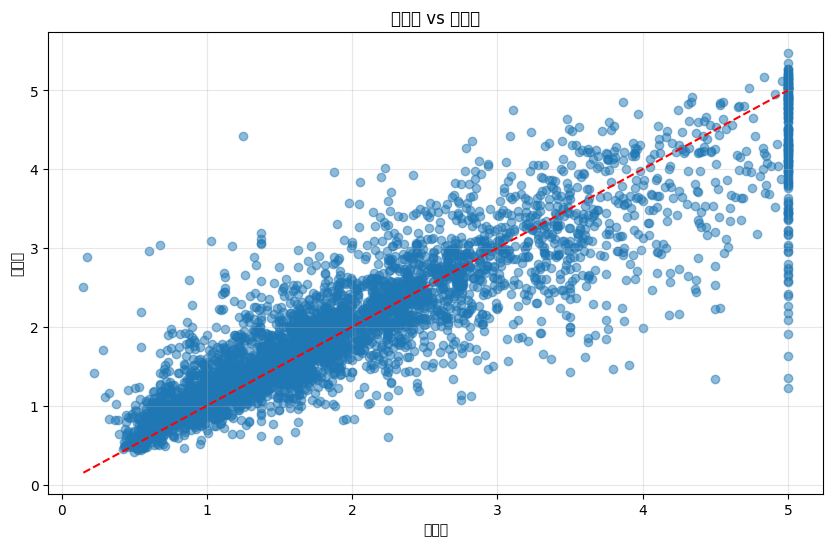

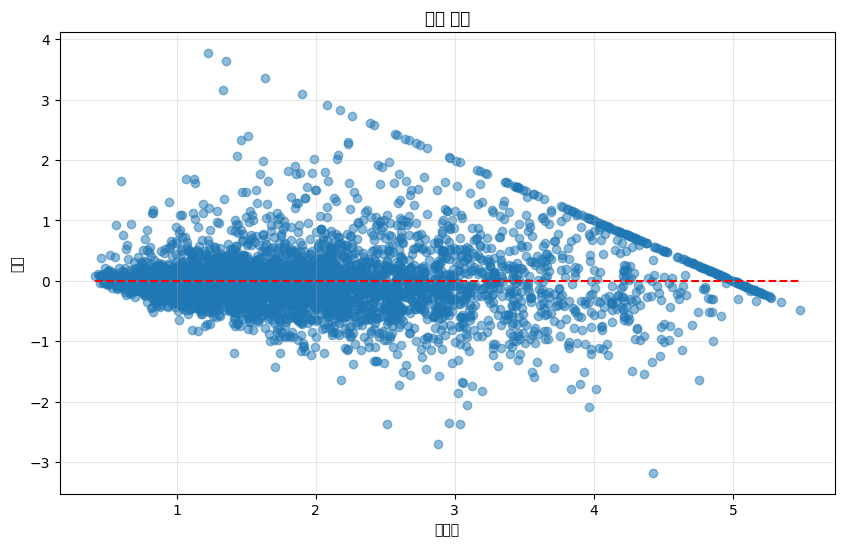

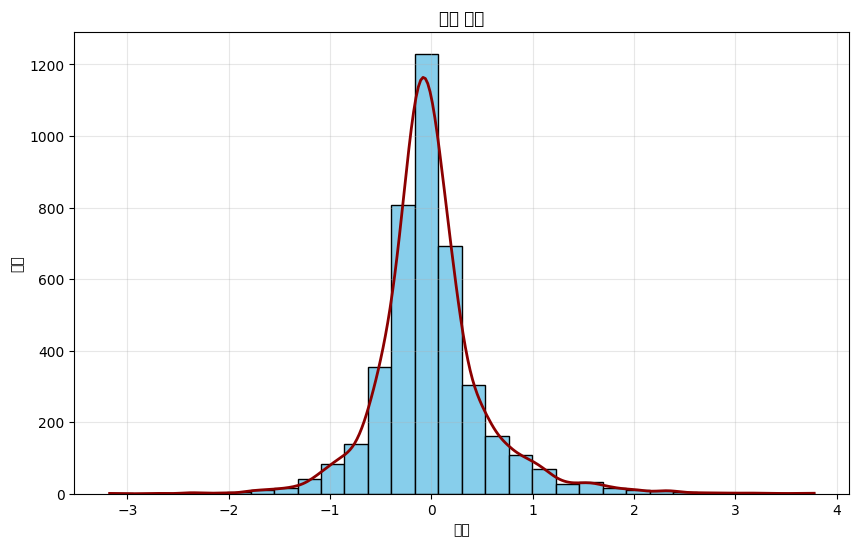

In [5]:
# 5. 예측
# 최고 성능 모델
best_model = results[best_model_name]['model']

# 테스트 데이터로 예측
test_predictions = best_model.predict(X_test)

# 예측값과 실제값의 산점도
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('실제값 vs 예측값')
plt.grid(True, alpha=0.3)
plt.show()

# 잔차 플롯
residuals = y_test - test_predictions

plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='--')
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.title('잔차 플롯')
plt.grid(True, alpha=0.3)
plt.show()

# 잔차 분포 히스토그램
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')

# 잔차 분포의 KDE 곡선 추가
kde = gaussian_kde(residuals)
x_vals = np.linspace(residuals.min(), residuals.max(), 300)
plt.plot(x_vals, kde(x_vals)*len(residuals)*(bins[1]-bins[0]), color='darkred', linewidth=2)
plt.title('잔차 분포')
plt.xlabel('잔차')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)
plt.show()



#################################################
#### 6. 성능 개선 
#################################################


XGBoost에 대한 하이퍼파라미터 튜닝 중...
최적 파라미터: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}
최적 RMSE: 0.5097

튜닝된 모델 성능:
  RMSE: 0.5085
  R^2: 0.8027

튜닝 전후 RMSE 개선율: 4.20%


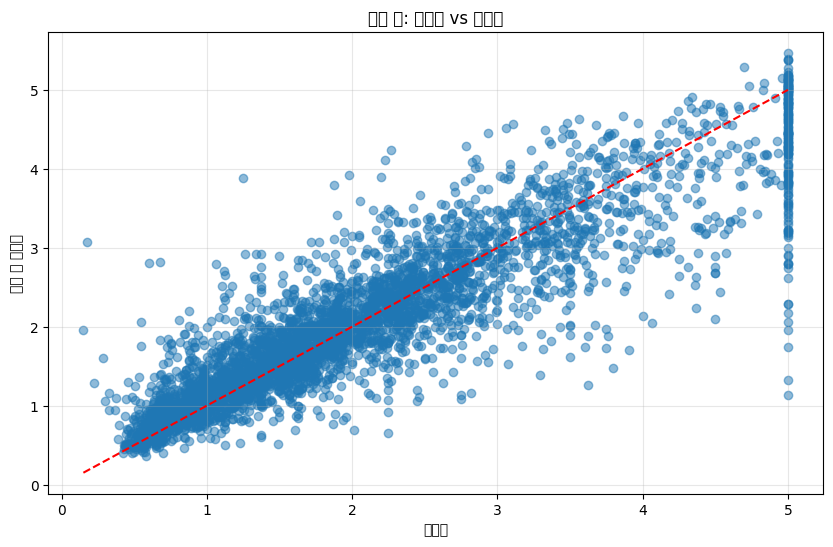

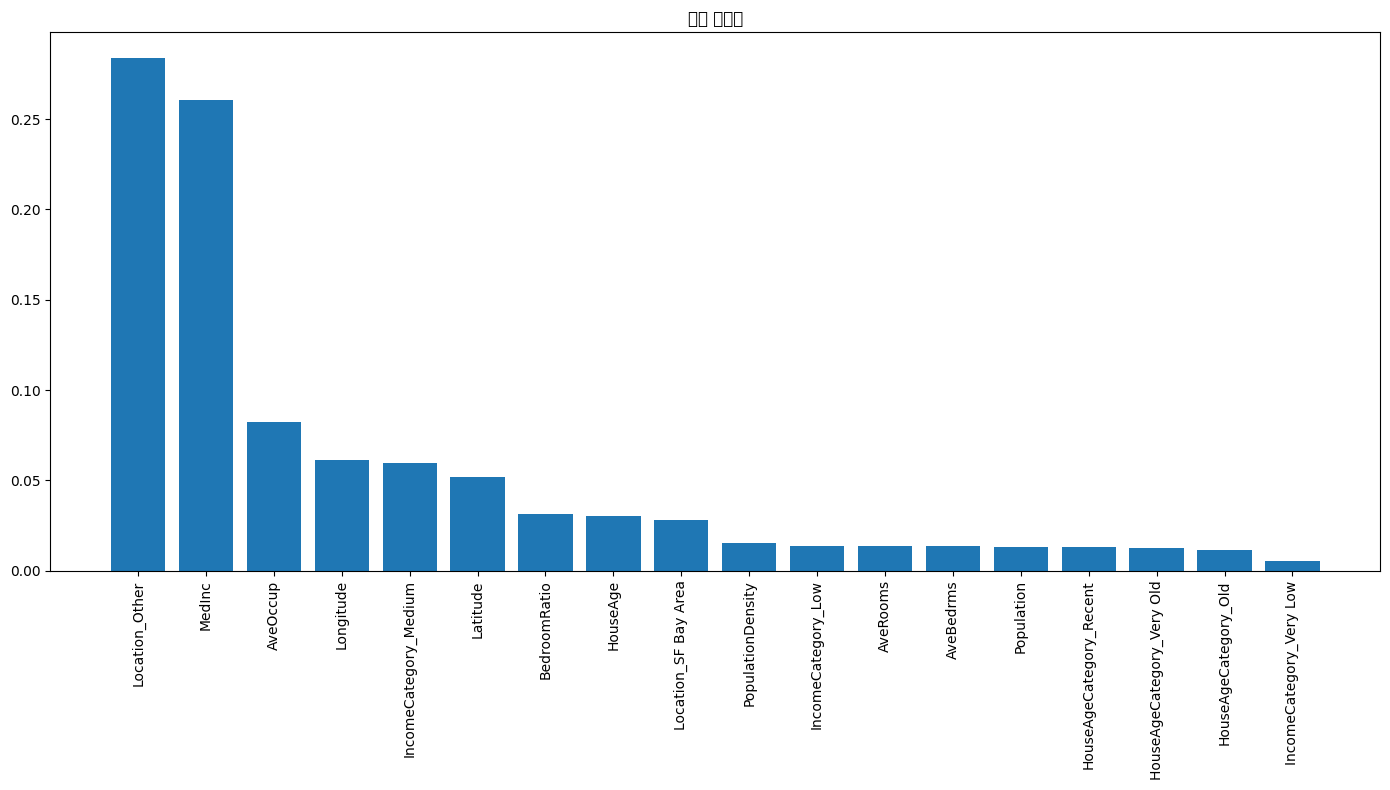


최종 모델이 'housing_final_model.pkl'로 저장되었습니다.


머신러닝 파이프라인 완료!


In [6]:
# 6. 성능 개선
from sklearn.model_selection import GridSearchCV

# 최고 성능 모델에 대한 하이퍼파라미터 튜닝
if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__subsample': [0.8, 0.9, 1.0],
        'regressor__colsample_bytree': [0.8, 0.9, 1.0]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name in ['Ridge Regression', 'Lasso Regression']:
    param_grid = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    }
else:  # Linear Regression은 주요 튜닝 파라미터가 없음
    param_grid = {}

# 그리드 서치 수행 (파라미터가 있는 경우)
if param_grid:
    print(f"\n{best_model_name}에 대한 하이퍼파라미터 튜닝 중...")
    grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        cv=5,  # 5-fold 교차 검증
        scoring='neg_mean_squared_error',  # 음수 MSE로 평가
        n_jobs=-1  # 모든 CPU 코어 사용
    )

    grid_search.fit(X_train, y_train)

    print("최적 파라미터:", grid_search.best_params_)
    print(f"최적 RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

    # 튜닝된 모델로 테스트 세트에서 평가
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)

    tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    tuned_r2 = r2_score(y_test, y_pred_tuned)

    print("\n튜닝된 모델 성능:")
    print(f"  RMSE: {tuned_rmse:.4f}")
    print(f"  R^2: {tuned_r2:.4f}")

    # 튜닝 전후 성능 비교
    improvement = (results[best_model_name]['rmse'] - tuned_rmse) / results[best_model_name]['rmse'] * 100
    print(f"\n튜닝 전후 RMSE 개선율: {improvement:.2f}%")

    # 최종 모델 업데이트
    final_model = tuned_model
else:
    print(f"\n{best_model_name}은(는) 주요 튜닝 파라미터가 없거나 필요하지 않습니다.")
    final_model = best_model

# 튜닝된 모델로 예측한 결과와 실제값 비교
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제값')
plt.ylabel('튜닝 후 예측값')
plt.title('튜닝 후: 실제값 vs 예측값')
plt.grid(True, alpha=0.3)
plt.show()

# 특성 중요도 (트리 기반 모델인 경우)
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    # 모델에서 특성 중요도 추출
    # 주의: Pipeline을 사용하기 때문에 조금 복잡함
    regressor = final_model.named_steps['regressor']
    preprocessor = final_model.named_steps['preprocessor']

    # 특성 이름 가져오기
    feature_names = []
    # 수치형 특성
    feature_names.extend(numeric_features)
    # 원핫 인코딩된 범주형 특성
    ohe = preprocessor.named_transformers_['cat']
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(ohe_feature_names)

    # 특성 중요도 시각화
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(14, 8))
    plt.title('특성 중요도')
    plt.bar(range(min(20, len(importances))), importances[indices[:20]], align='center')
    plt.xticks(range(min(20, len(importances))), [feature_names[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()

# 최종 모델 저장
joblib.dump(final_model, 'housing_final_model.pkl')
print("\n최종 모델이 'housing_final_model.pkl'로 저장되었습니다.")

print("\n\n머신러닝 파이프라인 완료!")
